# Analyze and Extract Data

## PART I: San Francisco Demand Pickups Data

Our goal is to scale down data and limit to regions/neighborhood with highest pickups count. We do that by sort pickups demand from high to low based on neighborhoods, and select top ones that make up 80% of total pickups.

After analyzing and filtering, there are total 19 neighborhoods selected for demand data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import shape
import json
import geopandas as gp
import numpy as np
from sklearn.cluster import DBSCAN
import contextily as cx
from datetime import datetime

plt.rcParams["figure.figsize"] = (25,12)

import warnings
warnings.filterwarnings('ignore')

In [2]:
trip_stats = pd.read_csv("raw_data/trip_stats_taz.csv")
trip_stats.head()

,taz,day_of_week,hour,pickups,dropoffs
0,1,0,3,0.6,0.4
1,1,0,4,0.0,0.4
2,1,0,5,0.6,0.6
3,1,0,6,0.8,1.0
4,1,0,7,0.6,0.8


In [3]:
trip_stats.shape

(164808, 5)

In [4]:
taz_boundaries = pd.read_json("raw_data/taz_boundaries.json")
taz_boundaries["geometry"] = taz_boundaries["geometry"].apply(lambda x: shape(json.loads(x)))
taz_boundaries.head()

,gid,taz,nhood,sq_mile,geometry
0,1,2005,East Bay,2.62483,"(POLYGON ((-122.236779003207 37.8828249984369,..."
1,2,1999,East Bay,0.25465,"(POLYGON ((-122.243379003205 37.8490259984398,..."
2,3,1998,East Bay,0.41488,"(POLYGON ((-122.264880003202 37.8395259984401,..."
3,4,2000,East Bay,0.26872,"(POLYGON ((-122.253080003204 37.8513259984393,..."
4,5,2001,East Bay,0.22250,"(POLYGON ((-122.265680003202 37.8447259984396,..."


In [5]:
df = pd.merge(trip_stats, taz_boundaries, how='inner', on = 'taz')
del trip_stats
df.head()

,taz,day_of_week,hour,pickups,dropoffs,gid,nhood,sq_mile,geometry
0,1,0,3,0.6,0.4,1265,Visitacion Valley,0.0334,"(POLYGON ((-122.41622413799 37.708328165756, -..."
1,1,0,4,0.0,0.4,1265,Visitacion Valley,0.0334,"(POLYGON ((-122.41622413799 37.708328165756, -..."
2,1,0,5,0.6,0.6,1265,Visitacion Valley,0.0334,"(POLYGON ((-122.41622413799 37.708328165756, -..."
3,1,0,6,0.8,1.0,1265,Visitacion Valley,0.0334,"(POLYGON ((-122.41622413799 37.708328165756, -..."
4,1,0,7,0.6,0.8,1265,Visitacion Valley,0.0334,"(POLYGON ((-122.41622413799 37.708328165756, -..."


In [6]:
pickups_df = df[["nhood", "pickups"]].groupby(["nhood"]).sum(["pickups"])\
.sort_values(by=['pickups'], ascending=False)

total_pickups = sum(pickups_df["pickups"])
pickups_df["percent"] = round(pickups_df["pickups"]*100/total_pickups, 2)
pickups_df

,pickups,percent
nhood,,
Mission,99914.75,8.24
Tenderloin,79707.35,6.57
Financial District,74398.60,6.13
Western SoMa,68686.15,5.66
Marina/Cow Hollow,66101.25,5.45
North Beach/Waterfront,63408.05,5.23
Eastern SoMa,59976.25,4.94
Western Addition,56603.25,4.67
Pacific Heights,55598.05,4.58


In [7]:
len(pickups_df.index.unique())

48

In [8]:
pickups_df[pickups_df["percent"] >= 2]["percent"].sum()

79.59

Those neighborhoods that are higher than 2% of total pickups account for almost 80% of overall pickups. So we'll focus on thos neighborhoods

In [9]:
# We will select only those neighborhoods that are higher than 2% of pickups
# Also, a little modification here to include Chinatown as it's between to "Financial District" and "Mission Bay" 
# with high pickups and we don't want an empty spot in the map later
selected_nhoods = list(pickups_df[pickups_df["percent"] >= 2].index) + ["Chinatown"]
selected_df = df[df["nhood"].isin(selected_nhoods)]

#### Let's visualize how it looks by average pickups per taz, per neighborhood

In [10]:
gdf_group = selected_df[["nhood", "taz","pickups"]]\
.groupby(["nhood", "taz"])\
.agg(avg_pickups=('pickups', np.mean)).reset_index()


taz_geometry = selected_df[["taz", "geometry"]]
taz_geometry_mask = taz_geometry["geometry"].apply(lambda geom: geom.wkb)
taz_geometry = taz_geometry.loc[taz_geometry_mask.drop_duplicates().index]

gdf_group = pd.merge(gdf_group, taz_geometry, how="inner", on="taz")

gdf = gp.GeoDataFrame(gdf_group, crs={'init': 'epsg:4326'}, geometry=gdf_group["geometry"])
gdf.head()

,nhood,taz,avg_pickups,geometry
0,Castro/Upper Market,173,4.428274,"MULTIPOLYGON (((-122.43202 37.75625, -122.4323..."
1,Castro/Upper Market,179,4.663690,"MULTIPOLYGON (((-122.43704 37.75916, -122.4368..."
2,Castro/Upper Market,181,3.818452,"MULTIPOLYGON (((-122.43233 37.75623, -122.4345..."
3,Castro/Upper Market,190,14.474107,"MULTIPOLYGON (((-122.43485 37.75929, -122.4347..."
4,Castro/Upper Market,196,5.524702,"MULTIPOLYGON (((-122.44461 37.76125, -122.4443..."


## Heatmap by pickups count

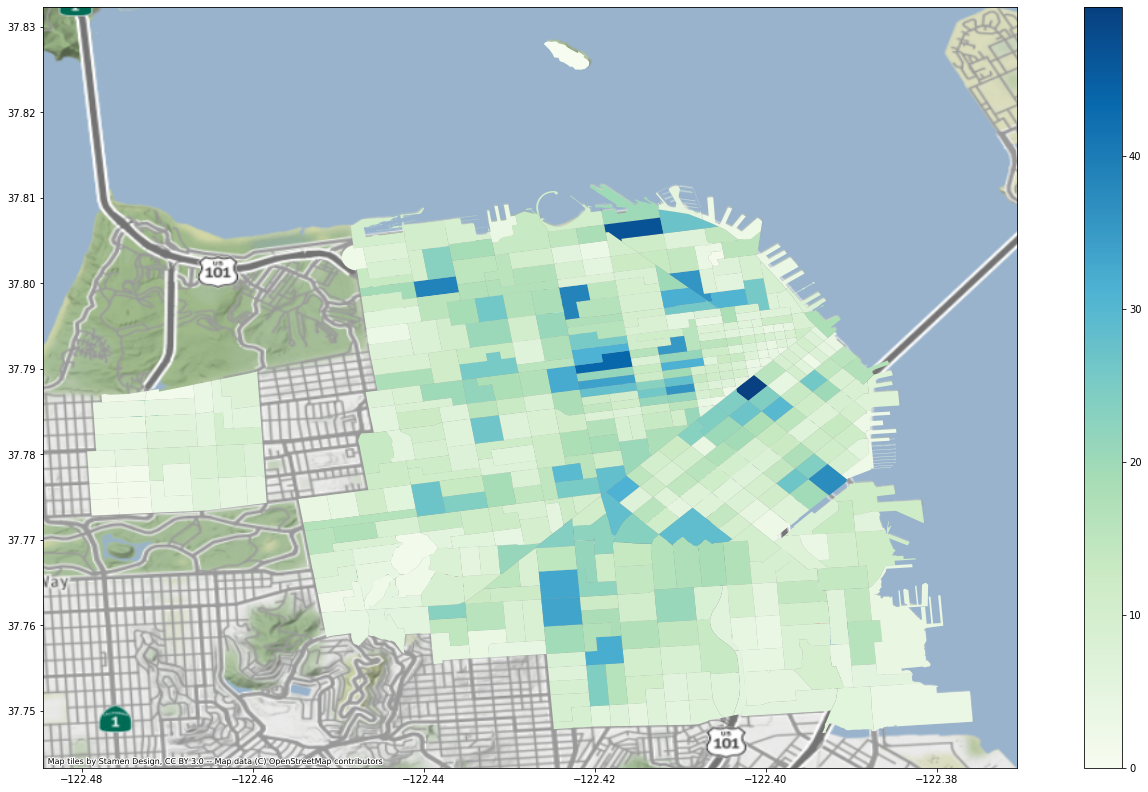

In [11]:
fig, ax = plt.subplots(figsize=(24, 14))
gdf.plot(column='avg_pickups', cmap='GnBu', markersize=0.1, ax=ax, legend=True)
cx.add_basemap(ax, crs=gdf.crs.to_string());

## Heatmap by neighborhoods

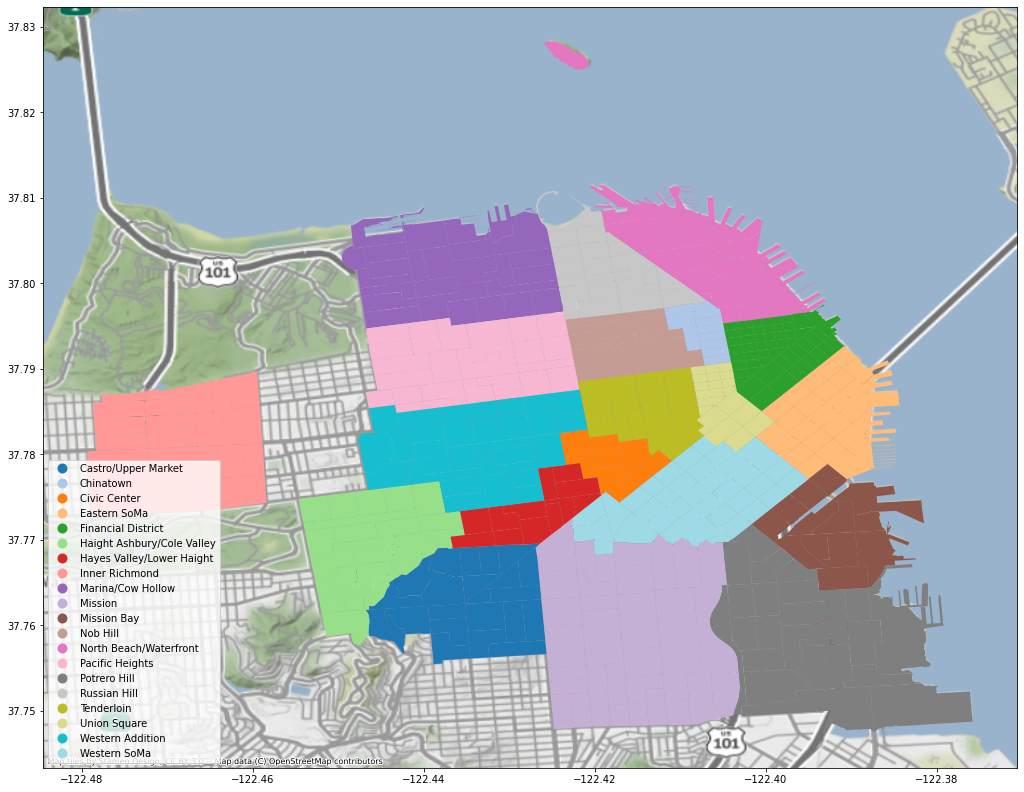

In [12]:
fig, ax = plt.subplots(figsize=(24, 14))
gdf.plot(column='nhood', markersize=0.1, cmap="tab20", ax=ax, legend=True, legend_kwds={'loc': 'lower left'})
cx.add_basemap(ax, crs=gdf.crs.to_string());

### Average pickups by neighborhood

In [13]:
# Group demand data into bucket of hours

# def bucket_map(val):
#     if val >= 0 and val < 7:
#         return "0-7"
#     elif val >=7 and val < 10:
#         return "7-10"
#     elif val >= 10 and val < 16:
#         return "10-16"
#     elif val >= 16 and val < 19:
#         return "16-19"
#     return "19-0"

# selected_df["hour_bucket"] = selected_df["hour"].apply(lambda x: bucket_map(x))

#demand_df = selected_df[["nhood", "day_of_week", "hour_bucket", "pickups"]]\
demand_df = selected_df[["nhood", "day_of_week", "hour", "pickups"]]\
.groupby(["nhood", "day_of_week", "hour"])\
.agg(avg_pickups=('pickups', np.mean),
    max_pickups=('pickups', np.max),
    min_pickups=('pickups', np.min)).round(2)\
.reset_index()
demand_df.head(10)

,nhood,day_of_week,hour,avg_pickups,max_pickups,min_pickups
0,Castro/Upper Market,0,3,0.80,3.2,0.0
1,Castro/Upper Market,0,4,0.95,3.0,0.0
2,Castro/Upper Market,0,5,1.97,7.4,0.4
3,Castro/Upper Market,0,6,3.02,7.6,0.0
4,Castro/Upper Market,0,7,6.20,13.6,1.0
5,Castro/Upper Market,0,8,6.87,14.2,1.0
6,Castro/Upper Market,0,9,8.38,23.0,2.0
7,Castro/Upper Market,0,10,5.68,18.4,0.8
8,Castro/Upper Market,0,11,4.72,12.8,1.2
9,Castro/Upper Market,0,12,5.22,12.0,1.6


In [14]:
demand_df.shape

(3360, 6)

## PART II: San Francisco Uber Movement Travel Times

We make some asumptions here:

1. We only consider intra-neighborhood trips, aka short trips
2. We only need trips that in the selected neighborhoods above.

We need to map those sourceid and destid within according neighborhoods

In [15]:
taz_sf = pd.read_json("raw_data/san_francisco_taz.json")

tazs = []
counties = []
movement_ids = []

def extract_info(row):
    try:
        taz = int(row["properties"].get("TAZ"))
    except:
        taz = None
        
    try:
        movement_id = int(row["properties"].get("MOVEMENT_ID"))
    except:
        movement_id = None
    tazs.append(taz)
    counties.append(row["properties"].get("COUNTY"))
    movement_ids.append(movement_id)
    
for row in taz_sf["features"]:
    extract_info(row)

taz_sf["taz"] = tazs
taz_sf["county"] = counties
taz_sf["movement_id"] = movement_ids

taz_sf.drop(labels=["type", "features"], axis=1, inplace=True)
taz_sf=taz_sf.dropna(subset=['taz','movement_id'])

taz_sf.head()

,taz,county,movement_id
0,706.0,007,0
1,708.0,007,1
2,704.0,007,2
3,710.0,007,3
4,720.0,007,4


In [16]:
taz_nhood = pd.merge(taz_sf, taz_boundaries, how="left", on="taz")
taz_nhood.head()

,taz,county,movement_id,gid,nhood,sq_mile,geometry
0,706.0,007,0,1970.0,Western Addition,0.02249,"(POLYGON ((-122.426440604274 37.7851549574982,..."
1,708.0,007,1,1972.0,Tenderloin,0.01188,"(POLYGON ((-122.416260122145 37.7853758002969,..."
2,704.0,007,2,1968.0,Tenderloin,0.01204,"(POLYGON ((-122.409682701039 37.7862028902855,..."
3,710.0,007,3,1974.0,Pacific Heights,0.02230,"(POLYGON ((-122.445020052304 37.7855483200653,..."
4,720.0,007,4,1984.0,Outer Richmond,0.02892,"(POLYGON ((-122.489807765947 37.7863117818364,..."


In [17]:
# Create a map between movement_id and nhood
taz_nhood_mapping = pd.Series(taz_nhood["nhood"].values,index=taz_nhood["movement_id"]).to_dict()

In [18]:
uber_df = pd.read_csv("raw_data/san_francisco-censustracts-2020-1-All-DatesByHourBucketsAggregate.csv")
uber_df.head()

,sourceid,dstid,month,day,start_hour,end_hour,mean_travel_time,standard_deviation_travel_time,geometric_mean_travel_time,geometric_standard_deviation_travel_time
0,1642,447,1,24,19,0,1252.43,357.51,1207.70,1.30
1,917,832,3,13,16,19,275.31,207.62,235.94,1.62
2,918,822,2,23,16,19,436.38,284.50,356.75,1.90
3,1066,2611,1,19,10,16,810.17,191.00,786.22,1.28
4,2694,533,1,18,10,16,723.02,242.06,688.74,1.36


In [19]:
uber_df["source_nhood"] = uber_df["sourceid"].apply(lambda x: taz_nhood_mapping.get(x))
uber_df["dest_nhood"] = uber_df["dstid"].apply(lambda x: taz_nhood_mapping.get(x))
uber_df = uber_df[((uber_df["source_nhood"] == uber_df["dest_nhood"]) |
                  (uber_df["geometric_mean_travel_time"] <= 30*60)) 
                                        & (uber_df["source_nhood"] != None)
                                        & (uber_df["source_nhood"].isin(selected_nhoods))]
uber_df.shape

(2903034, 12)

In [20]:
# Create a day_of_week column
uber_df["day_of_week"] = uber_df.apply(lambda row: datetime(2020, row["month"], row["day"]).weekday(), axis=1)

In [21]:
# Group by day_of_week and hour_bucket
uber_df_grouped = uber_df\
.groupby(["source_nhood", "day_of_week", "start_hour" , "end_hour"])\
.agg(
        total_travel_time= ('mean_travel_time', np.sum),
        avg_travel_time= ('mean_travel_time', np.mean),
        min_travel_time= ('mean_travel_time', np.min),
        max_travel_time= ('mean_travel_time', np.max)
    ).round(2)\
.reset_index()

uber_df_grouped.rename(columns={'source_nhood': 'nhood'}, inplace=True)

uber_df_grouped.head()

,nhood,day_of_week,start_hour,end_hour,total_travel_time,avg_travel_time,min_travel_time,max_travel_time
0,Castro/Upper Market,0,0,7,3148492.37,703.89,35.60,1981.40
1,Castro/Upper Market,0,7,10,3843218.76,743.23,48.80,2032.79
2,Castro/Upper Market,0,10,16,5945680.26,761.10,53.25,1930.63
3,Castro/Upper Market,0,16,19,3543891.51,738.62,32.00,1911.67
4,Castro/Upper Market,0,19,0,3751943.29,649.13,48.67,1828.22


In [22]:
# Note: Since we don't have specific hourly time, the travel_time within start and end hour will be
# used for each hour within it

uber_df = []
for index, row in uber_df_grouped.iterrows():
    start_hour = row["start_hour"]
    end_hour = row["end_hour"]
    for hour in range(start_hour, end_hour):
        uber_df.append([row["nhood"], row["day_of_week"], hour, row["avg_travel_time"],
                        row["min_travel_time"], row["max_travel_time"]])
        
travel_times_df = pd.DataFrame(uber_df, columns = ["nhood", "day_of_week", "hour", "avg_travel_time",
                                                   "min_travel_time", "max_travel_time"])

travel_times_df.head()

,nhood,day_of_week,hour,avg_travel_time,min_travel_time,max_travel_time
0,Castro/Upper Market,0,0,703.89,35.6,1981.4
1,Castro/Upper Market,0,1,703.89,35.6,1981.4
2,Castro/Upper Market,0,2,703.89,35.6,1981.4
3,Castro/Upper Market,0,3,703.89,35.6,1981.4
4,Castro/Upper Market,0,4,703.89,35.6,1981.4


In [23]:
travel_times_df.shape

(2527, 6)

In [24]:
combined = demand_df.merge(travel_times_df, how='outer', on=['nhood', 'day_of_week', 'hour'])

combined.head()

,nhood,day_of_week,hour,avg_pickups,max_pickups,min_pickups,avg_travel_time,min_travel_time,max_travel_time
0,Castro/Upper Market,0,3,0.80,3.2,0.0,703.89,35.6,1981.40
1,Castro/Upper Market,0,4,0.95,3.0,0.0,703.89,35.6,1981.40
2,Castro/Upper Market,0,5,1.97,7.4,0.4,703.89,35.6,1981.40
3,Castro/Upper Market,0,6,3.02,7.6,0.0,703.89,35.6,1981.40
4,Castro/Upper Market,0,7,6.20,13.6,1.0,743.23,48.8,2032.79


In [25]:
"""
Fill avg_travel_time, min_travel_time, max_travel_time of the missing time slot as the following order:
1. Values of the time slot before it
2. If not, values of the average, min and max of the whole neighborhood, min and max
"""

nhood_stats= combined[["nhood", "avg_travel_time", "min_travel_time", "max_travel_time"]]
nhood_stats = nhood_stats.dropna()
nhood_stats = nhood_stats.groupby(["nhood"])\
    .agg(avg_travel_time=('avg_travel_time', np.mean),
        min_travel_time=('min_travel_time', np.max),
        max_travel_time=('max_travel_time', np.min)).round(2)\
    .reset_index()

missing_null_idx = combined[combined.isna().any(axis=1)].index
no_uber_data_nhoods = []

print("Missing data before: ", len(missing_null_idx)) 

for idx in missing_null_idx:
    current_row_data = combined.loc[idx, :]
    current_row_data_hour = current_row_data["hour"]
    current_row_data_nhood = current_row_data["nhood"]

    previous_hour = current_row_data_hour - 1 if current_row_data_hour > 0 else 24
    next_row_data = combined[(combined["hour"] == current_row_data_hour - 1) &
                            (combined["day_of_week"] == current_row_data["day_of_week"]) &
                            (combined["nhood"] == current_row_data_nhood)]

    avg_travel_time = next_row_data['avg_travel_time'].values
    
    if avg_travel_time:
        avg_travel_time = avg_travel_time[0]
        min_travel_time = next_row_data['min_travel_time'].values[0]
        max_travel_time = next_row_data['max_travel_time'].values[0]
    else:
        nhood_stat = nhood_stats[nhood_stats["nhood"] == current_row_data_nhood]
        avg_travel_time = nhood_stat['avg_travel_time'].values
        if avg_travel_time:
            avg_travel_time = avg_travel_time[0]
            min_travel_time = nhood_stat['min_travel_time'].values[0]
            max_travel_time = nhood_stat['max_travel_time'].values[0]
        else:
            avg_travel_time = None
            min_travel_time = None
            max_travel_time = None
            if current_row_data_nhood not in no_uber_data_nhoods:
                no_uber_data_nhoods.append(current_row_data_nhood)
    
    combined.loc[idx, 'avg_travel_time'] = avg_travel_time
    combined.loc[idx, 'min_travel_time'] = min_travel_time
    combined.loc[idx, 'max_travel_time'] = max_travel_time

# Check that no missing data after
print("Missing data after: ", len(combined[combined.isna().any(axis=1)].index))
print("Neighborhood with missing uber data: ", no_uber_data_nhoods)

Missing data before:  1631
Missing data after:  567
Neighborhood with missing uber data:  ['Mission Bay']


In [26]:
# So we drop the nnhood Mission Bay since it doesn't have corresponding uber data
combined.dropna(inplace=True)
combined.shape

(3192, 9)

In [27]:
# Make a numeric columns from nhood and hour_bucket so we can plug in our model easier
combined["nhood_id"] = pd.Categorical(combined["nhood"], categories=combined["nhood"].unique()).codes

In [28]:
# Save final data
combined.to_csv("cleaned_data/uber_demand_travel_times.csv", index=False, header=True)

In [29]:
len(combined["nhood"].unique())

19

In [31]:
len(combined["hour"].unique())

24